In [ ]:
import os
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from pathlib import Path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
!pip install bertopic[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

df = pd.read_csv("/content/drive/MyDrive/TOPIC_MODELING/youtube_shorts_tiktok_trends_2025_labeled.csv")


In [ ]:
pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 13.9 MB/s eta 0:00:00


In [ ]:


import re
import emoji

def clean_text(x):
    if pd.isna(x):
        return ""
    x = str(x)

    # remove emojis
    x = emoji.replace_emoji(x, replace='')

    # remove URLs
    x = re.sub(r'http\S+|www.\S+', '', x)

    # keep ONLY letters and spaces (no digits, no underscores)
    x = re.sub(r'[^A-Za-z\s]', ' ', x)

    # collapse spaces
    x = re.sub(r'\s+', ' ', x).strip()

    return x.lower()


#filter the title clean
df['title_clean'] = df['title'].apply(clean_text)
df = df[df['title_clean'].str.len() > 2]
documents = df['title_clean'].tolist()

#show the 20 first ones
print("Remaining docs:", len(documents))
print(df['title_clean'].head(20).tolist())


Remaining docs: 48079
['night routine productivity', 'football skills in s', 'football skills in s', 'pro tips for valorant in s', 'pov budget', 'i flipped this sample', 'hours in istanbul', 'perfect cover', 'hours in seoul', 'study with me', 'grwm minimal look', 'makeup basics you need', 'cutest moments today', 'i tried making tacos', 'build this in minutes', 'dance with me evening', 'if productivity was honest', 'night routine budget', 'underrated artists to hear', 'grwm evening look']


In [ ]:
# Setting up the vectorizer with BM25 weighting if required, stopwords, and n-gram range
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words='english', min_df=5)
# UMAP
umap_model = UMAP(n_neighbors=20, n_components=5, metric='cosine')
# HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=15, min_samples=2, metric='euclidean', prediction_data=True)


In [ ]:
rep_model = KeyBERTInspired()

# Initialize BERTopic
topic_model = BERTopic(embedding_model="all-MiniLM-L6-v2", # Using `mpnet`
                       umap_model= umap_model,
                       hdbscan_model= hdbscan_model,
                       vectorizer_model=vectorizer_model,
                       calculate_probabilities=True,  # For viewing topic probabilities
                       seed_topic_list=None,  # Can be specified if you have seed topics
                       representation_model = rep_model,
                       verbose=True)

# Fit the model
topics, probs = topic_model.fit_transform(documents)

2025-11-15 06:33:34,952 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1503 [00:00<?, ?it/s]

2025-11-15 06:36:57,280 - BERTopic - Embedding - Completed ✓
2025-11-15 06:36:57,282 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-15 06:39:03,383 - BERTopic - Dimensionality - Completed ✓
2025-11-15 06:39:03,385 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-15 06:40:54,440 - BERTopic - Cluster - Completed ✓
2025-11-15 06:40:54,456 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-15 06:40:55,863 - BERTopic - Representation - Completed ✓


In [ ]:
# Define the path in Google Drive
save_dir = "/content/drive/MyDrive/TOPIC_MODELING/topic_modeling_tiktok/results_tiktok"
# Create the directory if it doesn’t exist
os.makedirs(save_dir, exist_ok=True)
# Save the full BERTopic model (not just a pickle)
topic_model.save(os.path.join(save_dir, "topic_model_tiktok"), serialization="all")
print("Model saved at:", os.path.join(save_dir, "topic_model_tiktok"))

Model saved at: /content/drive/MyDrive/TOPIC_MODELING/topic_modeling_tiktok/results_tiktok/topic_model_tiktok


In [ ]:
# Path to the saved model
# # Load the model
# topic_model = BERTopic.load(model_path)
model_path = "/content/drive/MyDrive/TOPIC_MODELING/topic_modeling_tiktok/results_tiktok/topic_model_tiktok"

# This loads the entire BERTopic model from that folder into memory. ---> restores everything from the training
# Load the full BERTopic model
topic_model = BERTopic.load(model_path)

In [ ]:
# ======================================================
# 1. LOAD CSV + RESTORE TOPIC ASSIGNMENTS
# ======================================================
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/TOPIC_MODELING/youtube_shorts_tiktok_trends_2025_labeled.csv")

# Clean titles again (must match training)
df["title_clean"] = df["title"].astype(str).apply(clean_text)
# Use the same cleaned titles the model was trained on
documents = df["title_clean"].tolist()
topics, probs = topic_model.transform(documents)
df["topic"] = topics
#show the titles, clean titles, virals, topics
print("Topic assignment restored on CLEAN TITLES.")
print(df[["title", "title_clean", "viral", "topic"]].head())


Batches:   0%|          | 0/1503 [00:00<?, ?it/s]

2025-11-15 07:54:38,270 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-11-15 07:54:57,128 - BERTopic - Dimensionality - Completed ✓
2025-11-15 07:54:57,130 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-11-15 07:54:59,366 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-11-15 07:56:54,516 - BERTopic - Probabilities - Completed ✓
2025-11-15 07:56:54,517 - BERTopic - Cluster - Completed ✓


Topic assignment restored on CLEAN TITLES.
                             title                 title_clean  viral  topic
0  Night Routine — Productivity 🏖️  night routine productivity      0    153
1         Football skills in 60s 📱        football skills in s      0      2
2           Football skills in 60s        football skills in s      0      2
3   Pro Tips for Valorant in 60s 🎮  pro tips for valorant in s      0    194
4                    POV: Budget 😂                  pov budget      0    143


In [ ]:
# -----------------------------------------------------------
# Filter out topics that have poor or missing keyword quality
# -----------------------------------------------------------
valid_topic_ids = []
for tid in range(len(topic_model.get_topic_info()) - 1):
    words = topic_model.get_topic(tid)
    if words is None:
        continue

    filtered = [(w, wt) for w, wt in words if isinstance(w, str) and w.strip() != ""]
    if len(filtered) >= 2:        # require at least 2 good words
        valid_topic_ids.append(tid)

print("Number of topics with good keywords:", len(valid_topic_ids))

viral_topic_ids = (
    df[df["viral"] == 1]["topic"]
    .value_counts()
    .index
    .tolist()
)

# keep only topics that have keywords
viral_topic_ids = [tid for tid in viral_topic_ids if tid in valid_topic_ids]

# take TOP 12 AFTER filtering
viral_topic_ids = viral_topic_ids[:12]

print("Final viral topic IDs used:", viral_topic_ids)

# -----------------------------------------------------------
# Build a clean dictionary of keywords for each viral topic
# -----------------------------------------------------------
cleaned_topics = {}
for tid in viral_topic_ids:
    raw = topic_model.get_topic(tid)
    filtered = [(w, wt) for w, wt in raw if isinstance(w, str) and w.strip() != ""]
    cleaned_topics[tid] = filtered

topic_labels = {
    tid: ", ".join([w for w, _ in cleaned_topics[tid][:2]])
    for tid in viral_topic_ids
}
# topic_labels is now a dictionary:
#    topic_id  →  "keyword1, keyword2"
# used later in plots to label bubbles, dendrogram leaves, etc.


Number of topics with good keywords: 77
Final viral topic IDs used: [155, 240, 110, 77, 204, 184, 79, 61, 182, 114, 153, 170]


In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-white")
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "figure.figsize": (14, 8),

    # remove spines
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,

    # no grid at all
    "axes.grid": False,

    # typography
    "axes.titleweight": "bold",
    "axes.titlesize": 20,
    "axes.labelsize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,

    # white background
    "axes.facecolor": "white",
    "figure.facecolor": "white"
})


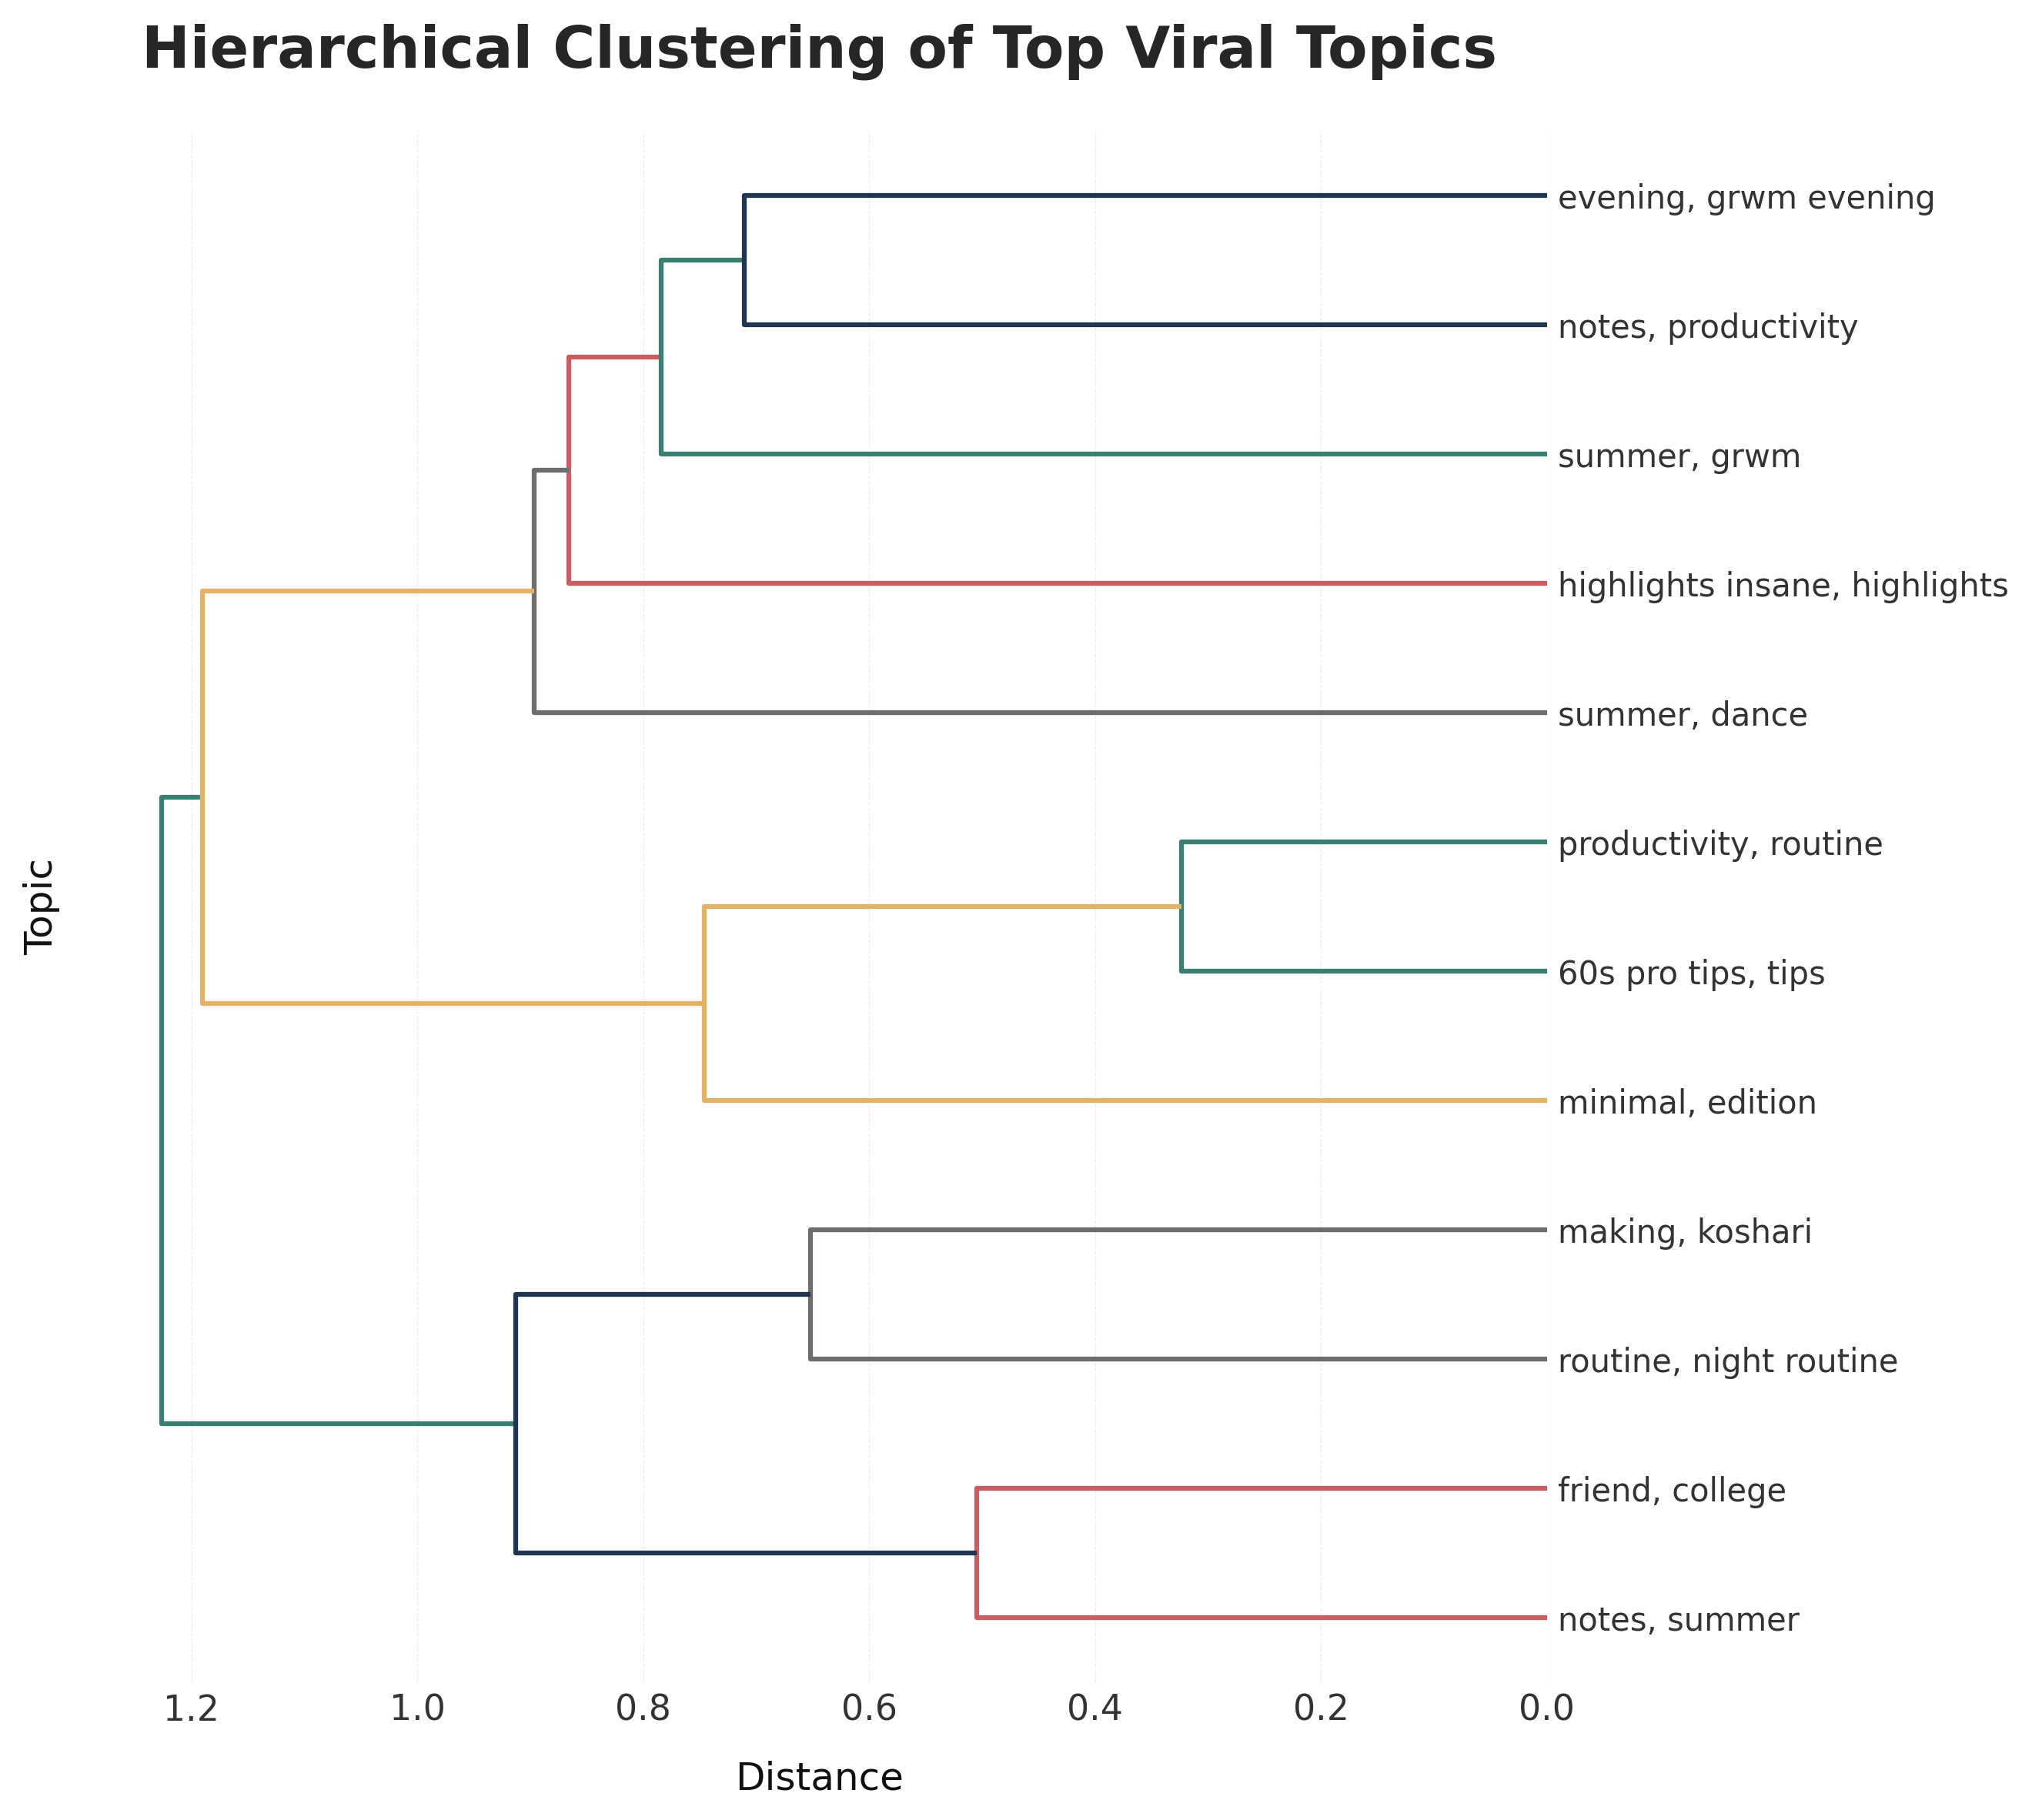

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.cluster.hierarchy import dendrogram

# Muted clean color palette
JS_COLORS = [
    "#1f3552",  # deep slate blue
    "#e2b266",  # muted amber
    "#3c7f72",  # calm green/teal
    "#c95d63",  # soft brick red
    "#6d6d6d"   # neutral gray
]

# Apply style globally
rcParams["font.family"] = "DejaVu Sans"
rcParams["font.size"] = 12
rcParams["axes.edgecolor"] = "#333333"
rcParams["axes.labelcolor"] = "#111111"
rcParams["xtick.color"] = "#333333"
rcParams["ytick.color"] = "#333333"

fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
#show the dendogram
dendrogram(
    linkage_matrix,
    labels=leaf_labels,
    orientation="left",
    leaf_font_size=10,
    color_threshold=1.0,
    above_threshold_color=JS_COLORS[0],
    link_color_func=lambda k: JS_COLORS[k % len(JS_COLORS)],
    ax=ax
)
# Title & labels
ax.set_title("Hierarchical Clustering of Top Viral Topics", fontsize=18, fontweight="bold", pad=20)
ax.set_xlabel("Distance", fontsize=12, labelpad=10)
ax.set_ylabel("Topic", fontsize=12, labelpad=10)
# Reduce white space around labels
plt.subplots_adjust(left=0.35, right=0.98, top=0.92, bottom=0.08)
# Clean styling
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
# Subtle grid
ax.grid(axis="x", linestyle="--", linewidth=0.3, alpha=0.35)
plt.show()
fig.savefig(
    "/content/drive/MyDrive/TOPIC_MODELING/topic_dendrogram_clean.png",
    dpi=400,
    bbox_inches="tight",
    facecolor="white"
)


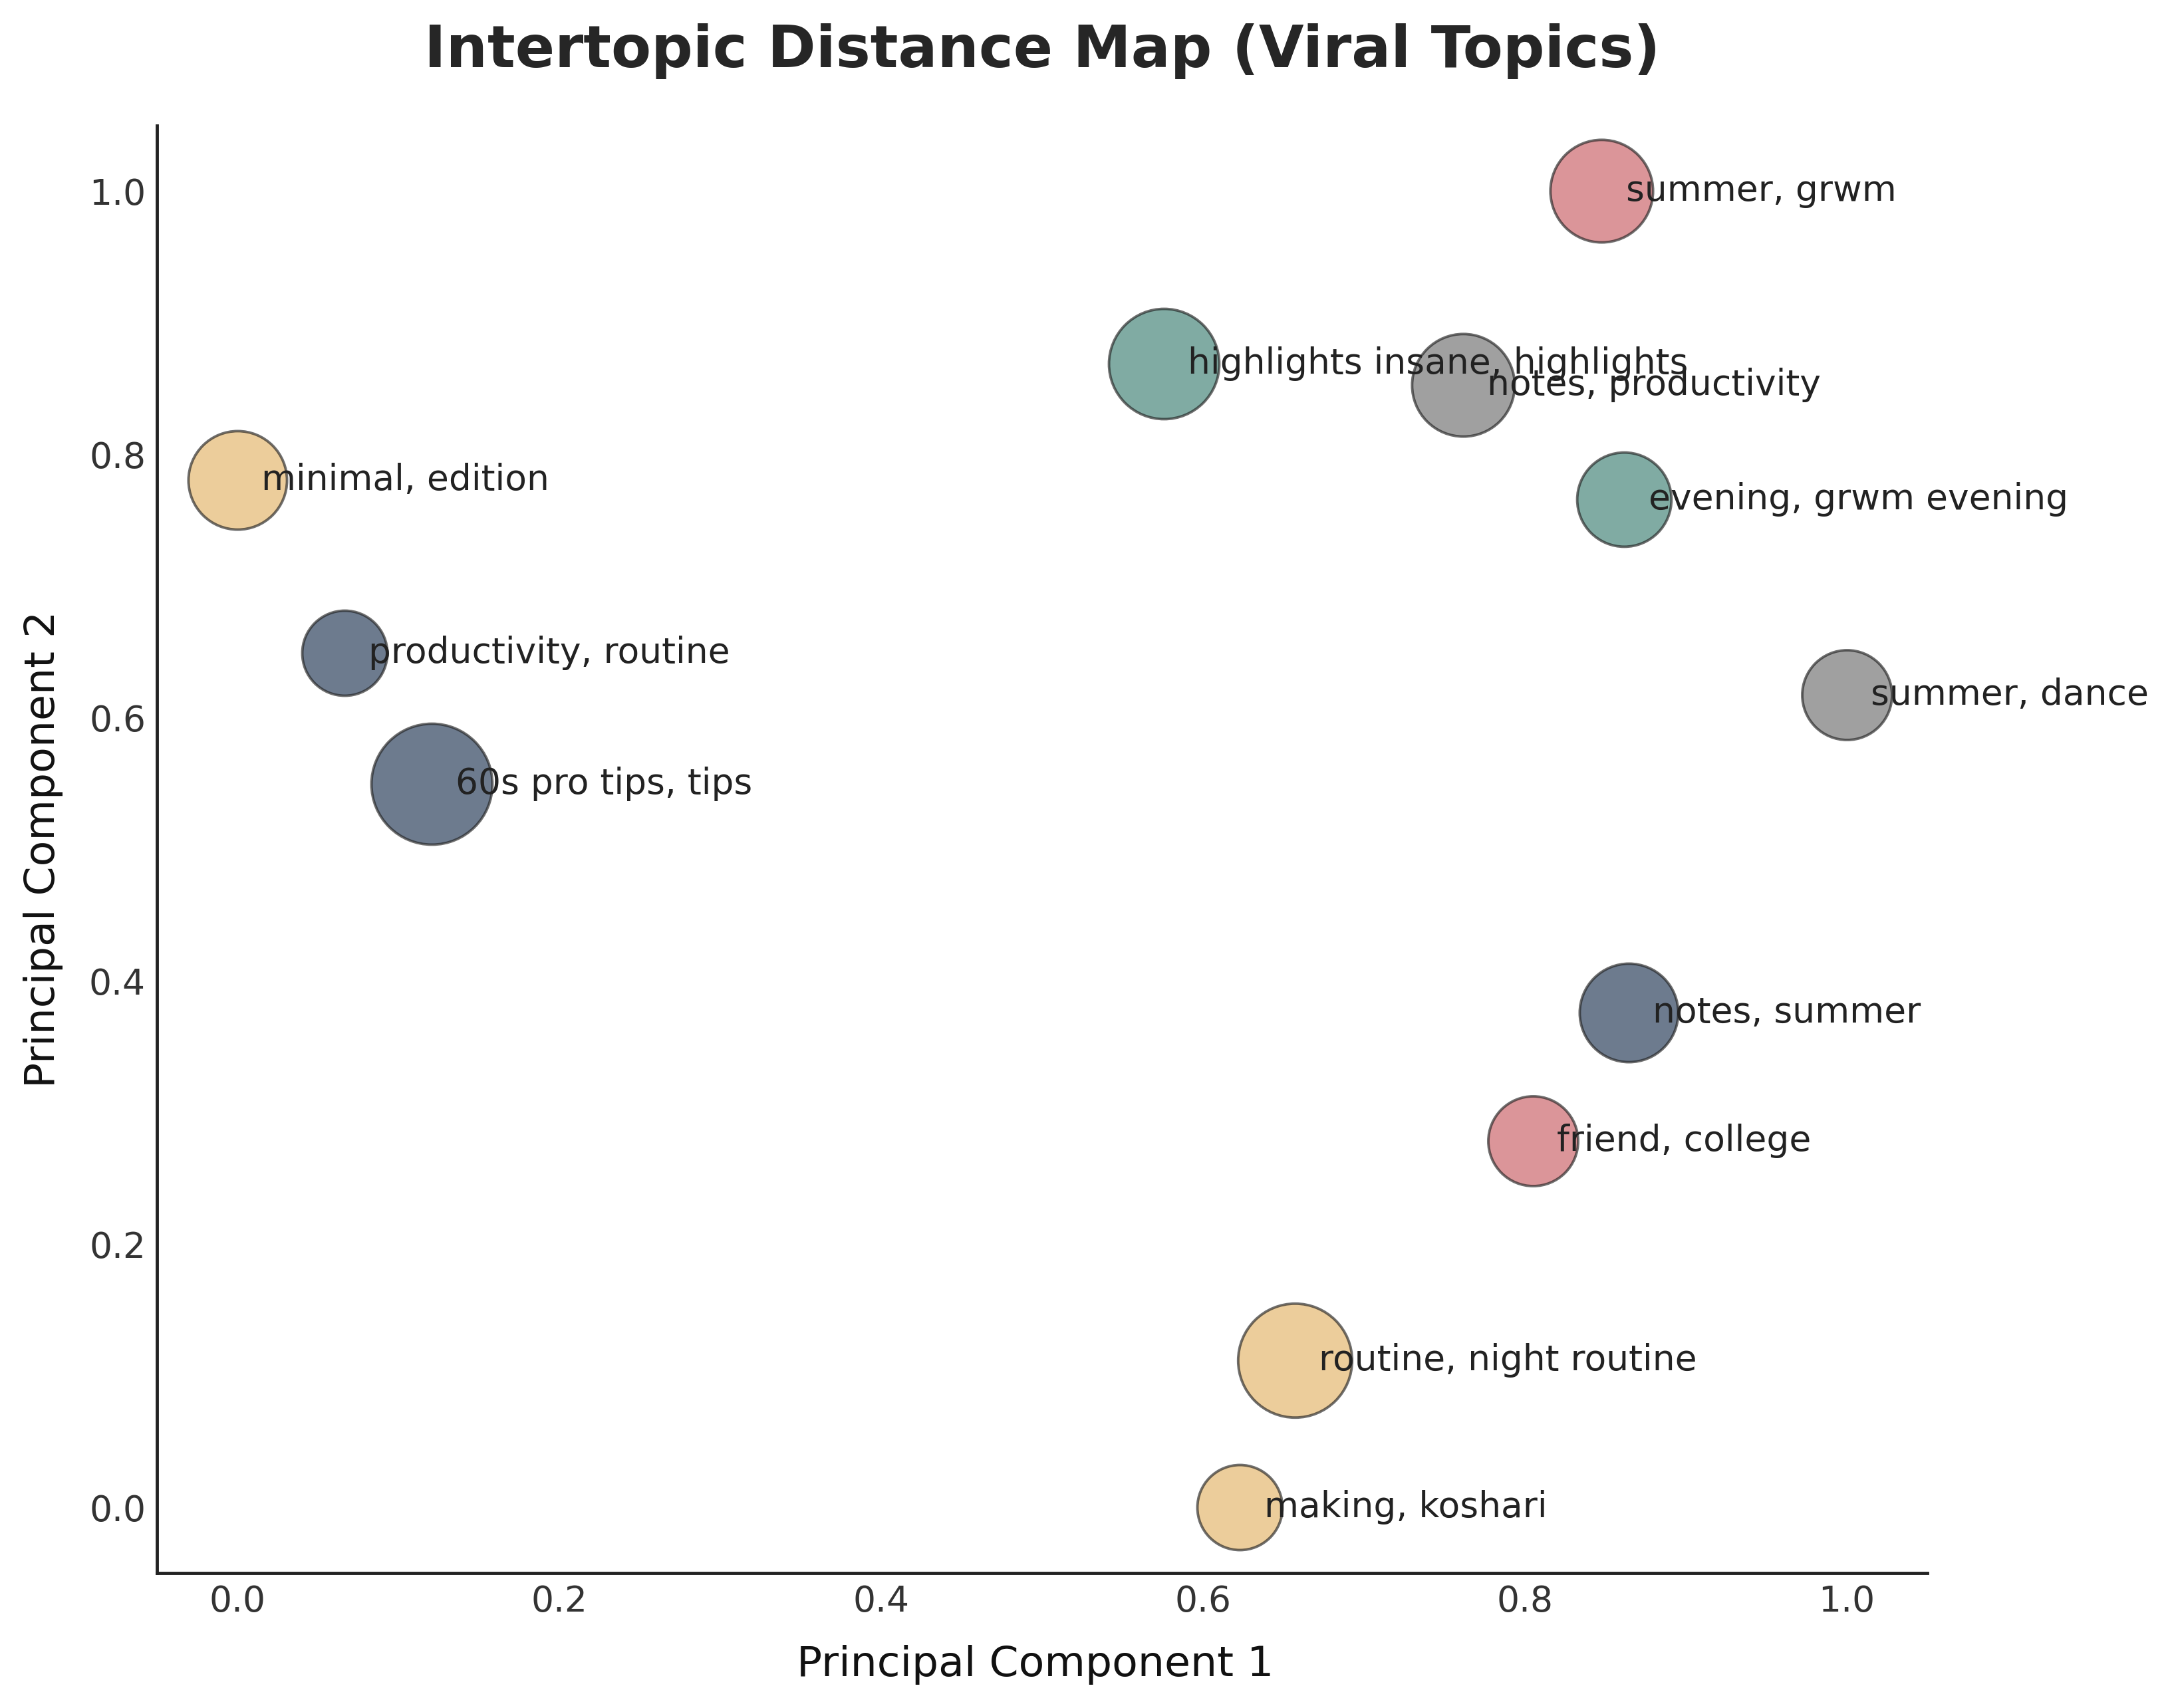

Saved to: /content/drive/MyDrive/TOPIC_MODELING/topic_intertopic_viral.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
JS_COLORS = [
    "#1f3552",  # deep slate blue
    "#e2b266",  # muted amber
    "#3c7f72",  # green/teal
    "#c95d63",  # brick red
    "#6d6d6d"   # neutral
]

rcParams["font.family"] = "DejaVu Sans"
rcParams["font.size"] = 12
rcParams["axes.edgecolor"] = "#222222"
rcParams["axes.labelcolor"] = "#111111"
rcParams["xtick.color"] = "#333333"
rcParams["ytick.color"] = "#333333"

# -----------------------------------------
#  TSNE ON VIRAL TOPICS ONLY
# -----------------------------------------
embeddings = topic_model.topic_embeddings_[viral_topic_ids]
tsne = TSNE(
    n_components=2,
    init="random",
    perplexity=3,
    learning_rate=50,
    random_state=0
)
coords = tsne.fit_transform(embeddings)
coords = MinMaxScaler().fit_transform(coords)

# topic frequency → bubble size
viral_counts = df[df["viral"] == 1]["topic"].value_counts()
sizes = np.array([viral_counts[tid] for tid in viral_topic_ids])
sizes = 1100 * (sizes / sizes.max()) + 300  # balanced bubble sizes

# -----------------------------------------
#  P L O T
# -----------------------------------------
fig, ax = plt.subplots(figsize=(9.5, 7.5), dpi=350)

for i, tid in enumerate(viral_topic_ids):
    ax.scatter(
        coords[i,0], coords[i,1],
        s=sizes[i],
        color=JS_COLORS[i % len(JS_COLORS)],
        alpha=0.65,
        linewidth=0.8,
        edgecolor="#222222",
        zorder=2
    )
    ax.text(
        coords[i,0] + 0.015,
        coords[i,1],
        topic_labels[tid],
        fontsize=11,
        ha="left",
        va="center",
        color="#222222",
        zorder=3
    )

# -----------------------------------------
#  C L E A N   S T Y L I N G
# -----------------------------------------

# remove grid, keep axes clean
ax.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
for spine in ["bottom", "left"]:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_linewidth(1.0)
    ax.spines[spine].set_color("#222222")

ax.set_xlabel("Principal Component 1 ", fontsize=13, labelpad=8)
ax.set_ylabel("Principal Component 2", fontsize=13, labelpad=8)
ax.set_title(
    "Intertopic Distance Map (Viral Topics)",
    fontsize=18,
    fontweight="bold",
    pad=18
)
plt.tight_layout()
save_path = "/content/drive/MyDrive/TOPIC_MODELING/topic_intertopic_viral.png"
fig.savefig(save_path, dpi=350, bbox_inches="tight")
plt.show()
print("Saved to:", save_path)


    topic_id  viral_rate      lift
9        114    0.063830  3.662139
5        184    0.035088  2.013106
0        155    0.033175  1.903387
1        240    0.030075  1.725519
8        182    0.027778  1.593709
7         61    0.025000  1.434338
11       170    0.022026  1.263734
3         77    0.020930  1.200841
2        110    0.017713  1.016278
6         79    0.016129  0.925379
10       153    0.013263  0.760922
4        204    0.012950  0.742966


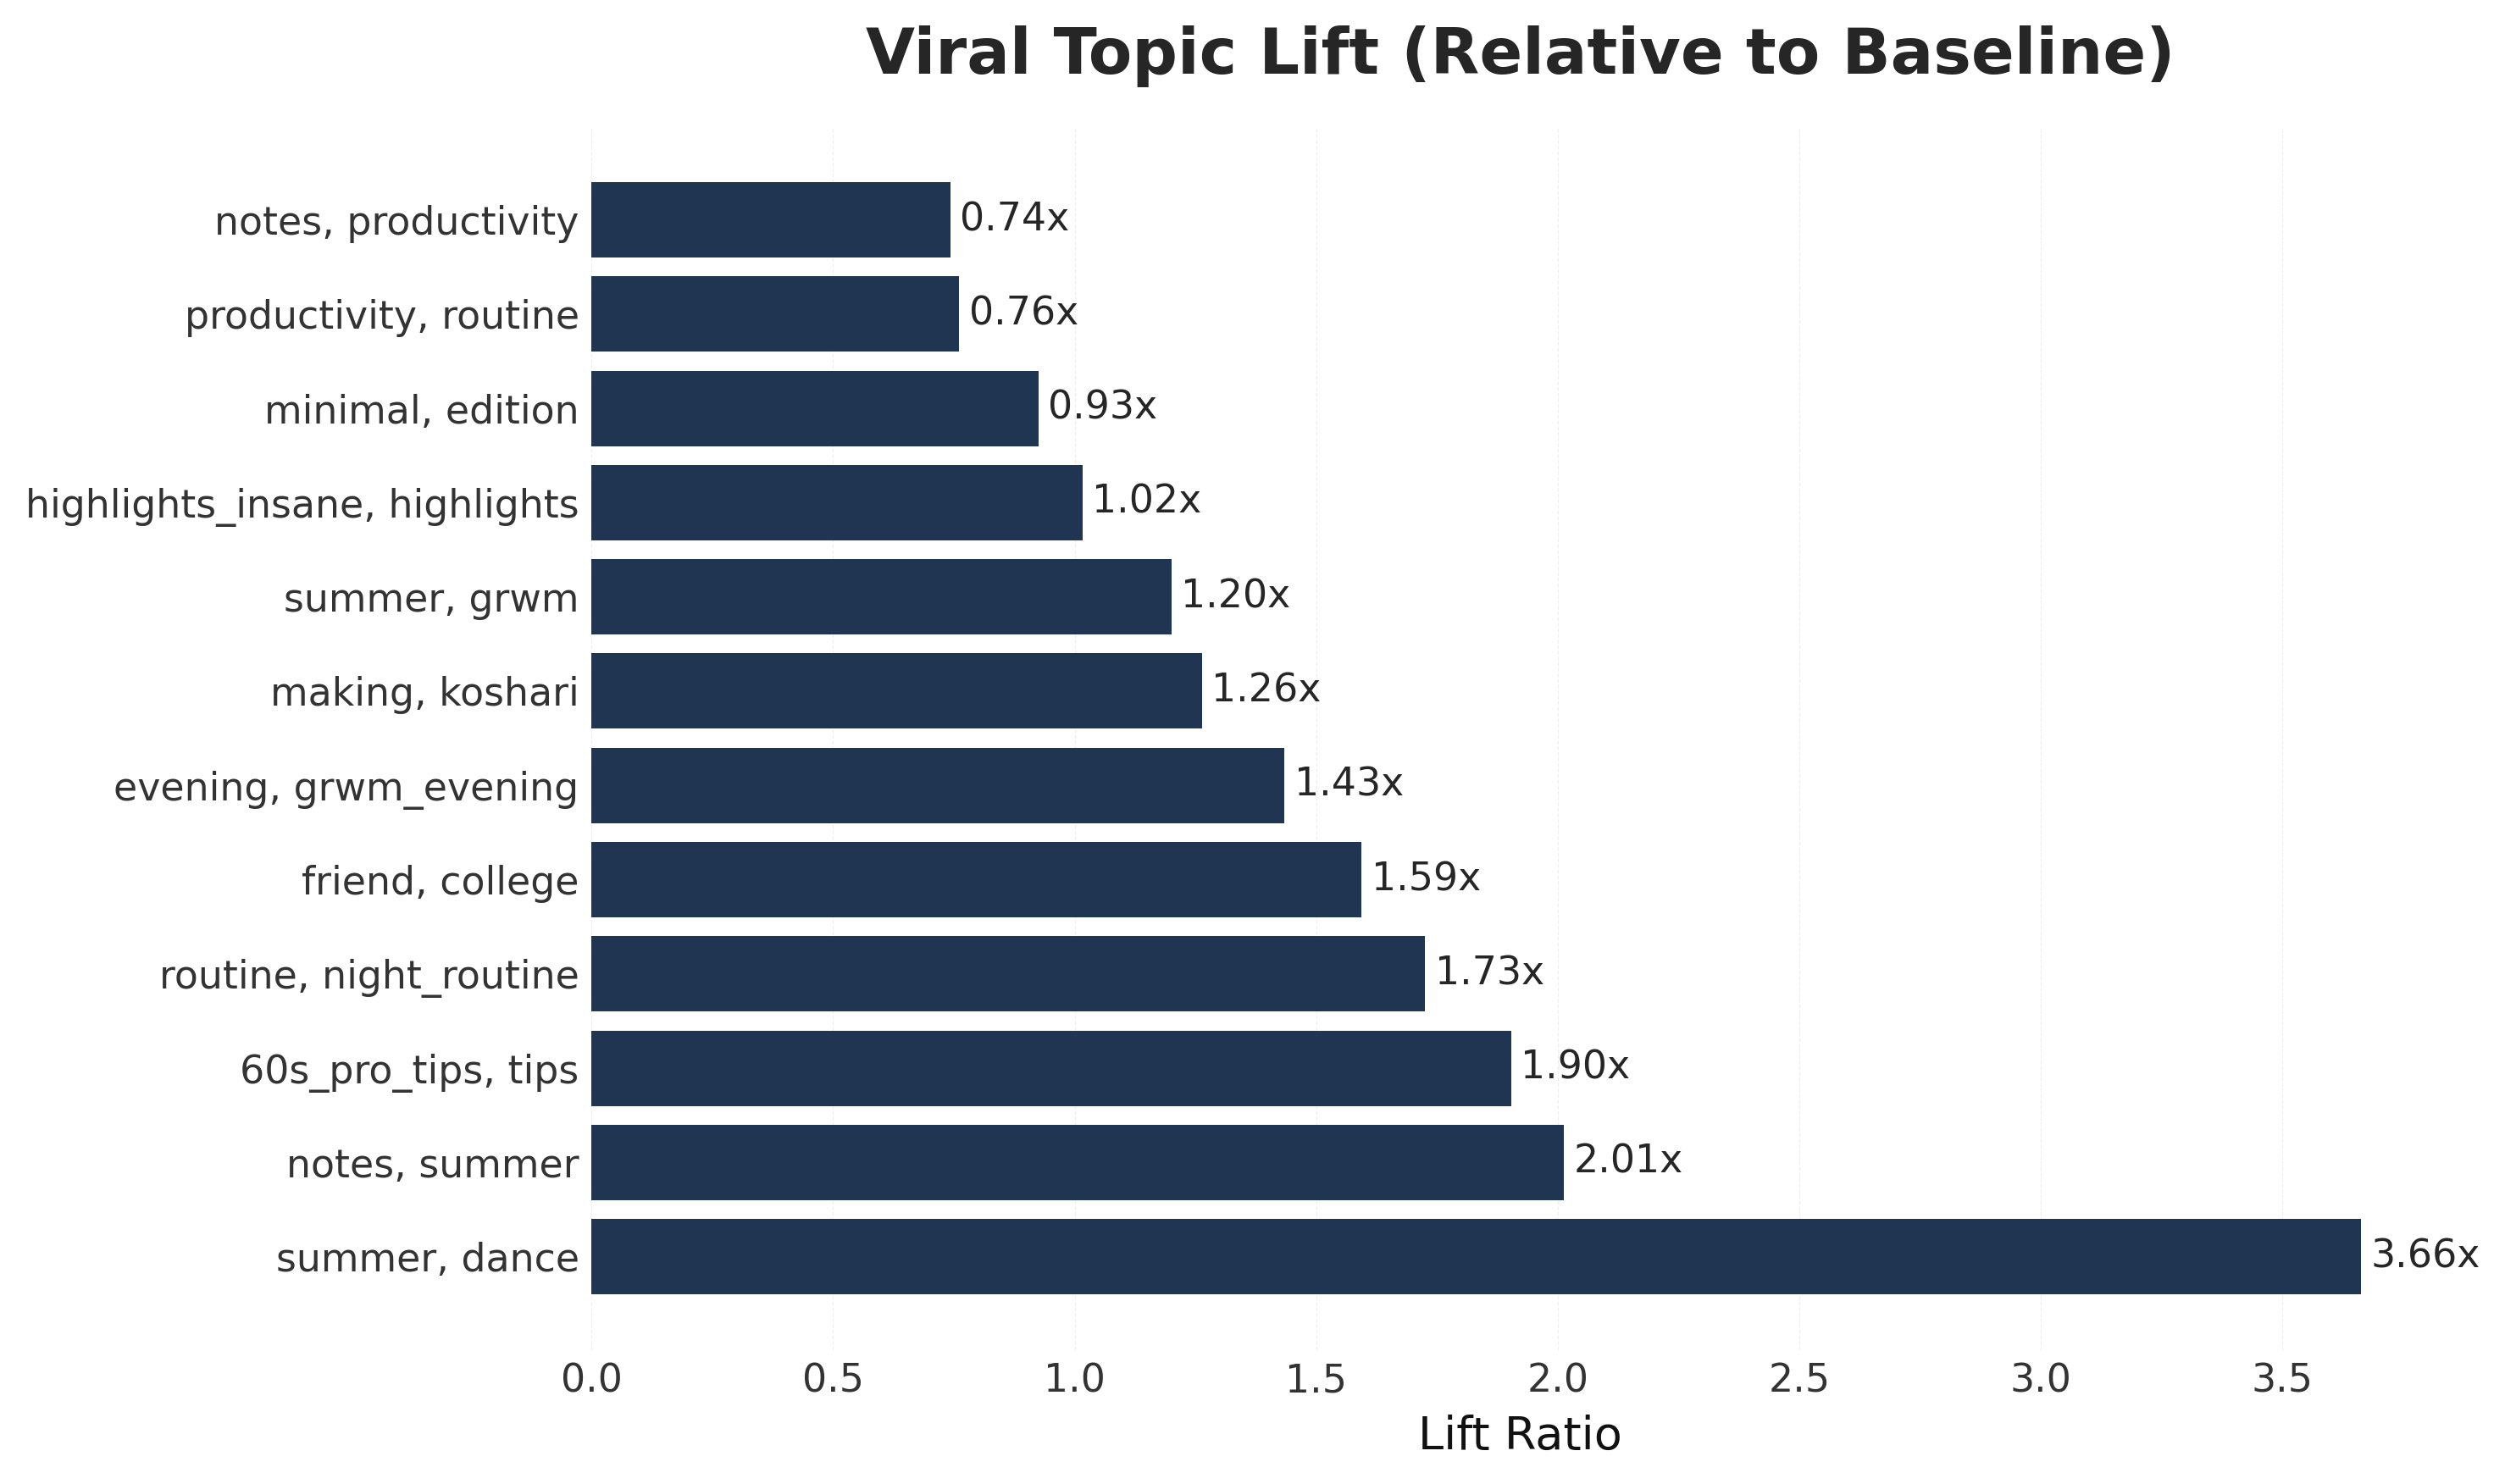

Saved to: /content/drive/MyDrive/TOPIC_MODELING/viral_topic_lift.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# ============================================
#  INPUTS FROM YOUR PIPELINE
# ============================================
# df: your dataframe with columns:
#   - title_clean
#   - viral (1/0)
#   - topic
# cleaned_topics: dict {topic_id: [(word, weight), ...]}
# viral_topic_ids: list of ~12 selected topics

# Build text labels (same as dendrogram)
topic_labels = {}
for tid, words in cleaned_topics.items():
    top_words = [w.replace(" ", "_") for w, _ in words[:2]]
    topic_labels[tid] = ", ".join(top_words)


# ============================================
#   COMPUTE VIRAL LIFT
# ============================================
overall_rate = df["viral"].mean()

topic_stats = []
for tid in viral_topic_ids:
    sub = df[df["topic"] == tid]
    viral_rate = sub["viral"].mean()
    lift = viral_rate / overall_rate
    topic_stats.append((tid, viral_rate, lift))
topic_stats = pd.DataFrame(topic_stats, columns=["topic_id", "viral_rate", "lift"])
topic_stats.sort_values("lift", ascending=False, inplace=True)
print(topic_stats)
JS_COLORS = [
    "#1f3552",  # deep slate blue
    "#e2b266",  # muted amber
    "#3c7f72",  # calm green
    "#c95d63",  # soft brick red
    "#6d6d6d"   # neutral gray
]
rcParams["font.family"] = "DejaVu Sans"
rcParams["font.size"] = 12
rcParams["axes.edgecolor"] = "#222222"
rcParams["axes.labelcolor"] = "#111111"
rcParams["xtick.color"] = "#333333"
rcParams["ytick.color"] = "#333333"
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
bars = ax.barh(
    topic_stats["topic_id"].astype(str),
    topic_stats["lift"],
    color=JS_COLORS[0]
)
# Apply text labels on bars
for i, v in enumerate(topic_stats["lift"]):
    ax.text(
        v + 0.02, i,
        f"{v:.2f}x",
        va="center",
        fontsize=11
    )
# Replace topic_ids with your readable labels
ax.set_yticklabels([topic_labels[tid] for tid in topic_stats["topic_id"]])
ax.set_title("Viral Topic Lift (Relative to Baseline)", fontsize=18, fontweight="bold", pad=15)
ax.set_xlabel("Lift Ratio", fontsize=13)
# Clean up visuals
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.grid(axis="x", linestyle="--", linewidth=0.3, alpha=0.3)
plt.tight_layout()
plt.show()
# -----------------------------------------
#  SAVE FIGURE (same style as your t-SNE)
# -----------------------------------------
save_path = "/content/drive/MyDrive/TOPIC_MODELING/viral_topic_lift.png"
fig.savefig(save_path, dpi=350, bbox_inches="tight")
print("Saved to:", save_path)

In [ ]:
# Viewing topics
for topic_num in range(len(topic_model.get_topic_info()) - 1):  # -1 to exclude the -1 (outlier) topic
    print(f"Topic {topic_num}: {topic_model.get_topic(topic_num)}")

# Initialize an empty list to collect topic data
topics_data = []

# Get the number of topics minus the outlier topic
num_topics = len(topic_model.get_topic_info()) - 1

# Iterate over each topic
for topic_num in range(num_topics):
    # Get the topic based on topic number
    topic = topic_model.get_topic(topic_num)

    # Each topic is a list of (word, weight) tuples
    for word, weight in topic:
        # Append the topic number, word, and weight as a tuple to the topics_data list
        topics_data.append((topic_num, word, weight))

# Convert the list of tuples into a DataFrame
topics_df = pd.DataFrame(topics_data, columns=['Topic', 'Word', 'Weight'])

# Display the DataFrame
print(topics_df)

topics_df.to_csv('topic_keywords_2.csv', index=False)

#structure is
# (topic_number): [(word_1, weight_1), (word_2, weight_2), ..., (word_n, weight_n)]
# e.g.
# Topic 60: [('evening', 0.4538), ('dance', 0.2783), ('', 0.2374), ..., ('', 0.2374)]
# Topic 60 is likely related to "evening" and "dance"
# clean the titles? or filter emojis or maybe work with what i have here

Topic 0: [('', np.float32(0.23007613)), ('', np.float32(0.23007613)), ('', np.float32(0.23007613)), ('', np.float32(0.23007613)), ('', np.float32(0.23007613)), ('', np.float32(0.23007613)), ('', np.float32(0.23007613)), ('', np.float32(0.23007613)), ('', np.float32(0.23007613)), ('', np.float32(0.23007613))]
Topic 1: [('dance', np.float32(0.25395173)), ('', np.float32(0.21242282)), ('', np.float32(0.21242282)), ('', np.float32(0.21242282)), ('', np.float32(0.21242282)), ('', np.float32(0.21242282)), ('', np.float32(0.21242282)), ('', np.float32(0.21242282)), ('', np.float32(0.21242282)), ('', np.float32(0.21242282))]
Topic 2: [('', np.float32(0.15662369)), ('', np.float32(0.15662369)), ('', np.float32(0.15662369)), ('', np.float32(0.15662369)), ('', np.float32(0.15662369)), ('', np.float32(0.15662369)), ('', np.float32(0.15662369)), ('', np.float32(0.15662369)), ('', np.float32(0.15662369)), ('', np.float32(0.15662369))]
Topic 3: [('', np.float32(0.21911213)), ('', np.float32(0.2191121